# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os

In [2]:
rls_list = []

for simulate_snpset in ["hm3", "imputed"]:
    for estimate_snpset in ["hm3", "imputed"]:
        for pcausal in [0.005, 0.1, 1.0]:
            for rho in [0.5, 0.8, 1.0]:
                f_name = f"out/estimate/snpset-{simulate_snpset}-varg-1.0-pcausal-{pcausal}-rho-{rho}.{estimate_snpset}.estimate.json"
                if not os.path.exists(f_name):
                    continue
                with open(f_name) as f:
                    data = json.load(f)

                    df_tmp = pd.DataFrame(
                        np.array([d["estimate"] for d in data]),
                        columns=["estimated_var_g", "estimated_rho", "estimated_var_e"],
                    )
                    df_tmp["simulate_snpset"] = simulate_snpset
                    df_tmp["estimate_snpset"] = estimate_snpset
                    df_tmp["rho"] = rho
                    df_tmp["pcausal"] = pcausal
                    rls_list.append(df_tmp)

df_plot = pd.concat(rls_list)
df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

In [17]:
df_tmp = df_plot[
    (df_plot.simulate_snpset == "imputed") & (df_plot.estimate_snpset == "imputed")
]

Text(0, 0.5, 'Estimated $r_g$')

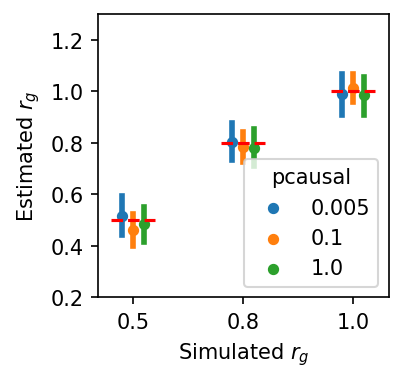

In [18]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150, sharex=True, sharey=True)
sns.pointplot(
    data=df_tmp,
    x="rho",
    y="estimated_ratio",
    hue="pcausal",
    dodge=0.2,
    join=False,
    ax=ax,
    markers=".",
)

list_rho = df_plot.rho.unique()

ax.hlines(
    list_rho,
    np.arange(len(list_rho)) - 0.2,
    np.arange(len(list_rho)) + 0.2,
    color="red",
    ls="--",
    zorder=10,
)
ax.set_ylim(0.2, 1.3)
ax.set_xlabel("Simulated $r_g$")
ax.set_ylabel("Estimated $r_g$")